# Price Analysis

**TODO:** we have 3 analysis to do to include in the final presentation, these are:

* Sales range analysis, we need to know how the prices to reailers are behaving, something like if the discounts that `SnaCo` is making to some clients are worth it or not.
* Trends of products in time per client or per distributor, this will tell us a strategy to offert this kind of products to some tipe of clients, like for example a regression to see the slope and if we have negative slope we can implement a promotion for this product.
* Devolutions problem, how can we analyze this? what clients are returning products and how this represents a problem for the company? how we can present this?
* The problem with offices seling product not in their local warehouse, how costs of shipping could impact the revenue of the company?

In [25]:
import datetime
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

random.seed(42)

In [26]:
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')

snacks_df = pd.read_csv('./datasets/clean_snacks.csv', dtype={ 'client_id': str }, parse_dates=['date'], date_parser=dateparse)
snacks_df['product_id'] = snacks_df['product_id'].astype(str)
snacks_df.head(1)

,office,warehouse,category,brand,product_id,flavor,client,point_of_sale,distributor,date,units,devolution_units,sale_amount,sale_discount,sale_devolution,incentive
0,Cali,Tulua,Producto De Extrusion,Cheetos,53407164,Tradicional,NaN,NaN,Tiendas,2014-04-01,324,0,181530.0,32675.4,-0.0,True


We want to count the products to leave only those product that have a good amount of records, select some of those at random and start making the prices analysis for those.

In [27]:
# We do not care on devolution records so we are going to analyze units > 0
snacks_df = snacks_df[snacks_df['units'] > 0]

product_grouping = (
    snacks_df.groupby('product_id')['units']
        .count()
        .reset_index()
        .rename(columns={'units': 'count'})
        .sort_values('count', ascending=False)
)

# we are going to select only products with more than 10k records, we don't know the exact number to consider as
# a good starting point, but we are going to try 10k and see what happens and then adjust this.

products = product_grouping[product_grouping['count'] > 10000]['product_id']
f"Now we have {len(products)} products"

'Now we have 27 products'

Now let's select 6 random products from that list and analyze what is happening with prices for those products

In [28]:
products_sample = products.sample(10)

products_df = snacks_df[snacks_df['product_id'].isin(products_sample)]
f"Now we have {len(products_df)} records"

'Now we have 190330 records'

Let's calculate the unit price for each sale and then view the distribution of those prices to have a general idea on how this prices behave.

In [29]:
products_df['unit_price'] = products_df['sale_amount'] / products_df['units']

/Users/juanprq/anaconda3/envs/week8/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


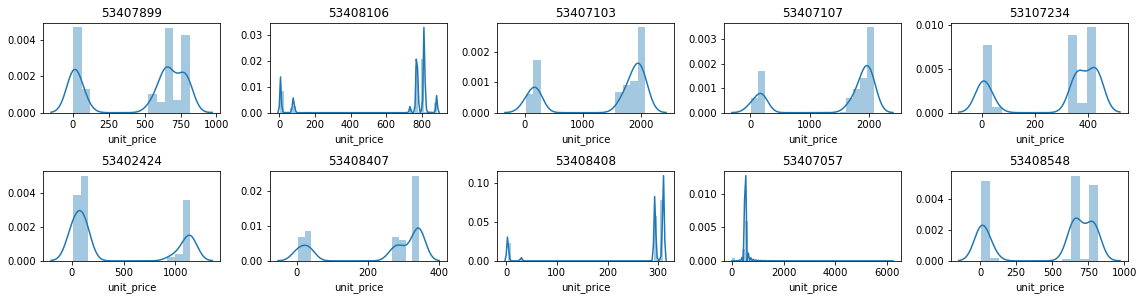

In [30]:
plt.figure(figsize=(16, 10))

for index, product in enumerate(products_df['product_id'].unique()):
    plt.subplot(5, 5, index + 1)
    sns.distplot(products_df[products_df['product_id'] == product]['unit_price']).set_title(product)
plt.tight_layout()

We can see a very interesting pattern in here, it seems that all products handle two types of prices, it's like all price units are bimodal.

* why is this happening? maybe it's something related to the year? or by distributor or client?
* why there is such a huge difference between expectations, it seems like some products are almost 0, but others are selled almost by 1000 pesos?

Let's divide by year to see the distribution of the products

In [31]:
products_df['month'] = products_df['date'].dt.month
products_df['year'] = products_df['date'].dt.year
products_df['yyyymm'] = products_df['date'].dt.to_period('M')

/Users/juanprq/anaconda3/envs/week8/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/juanprq/anaconda3/envs/week8/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/juanprq/anaconda3/envs/week8/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

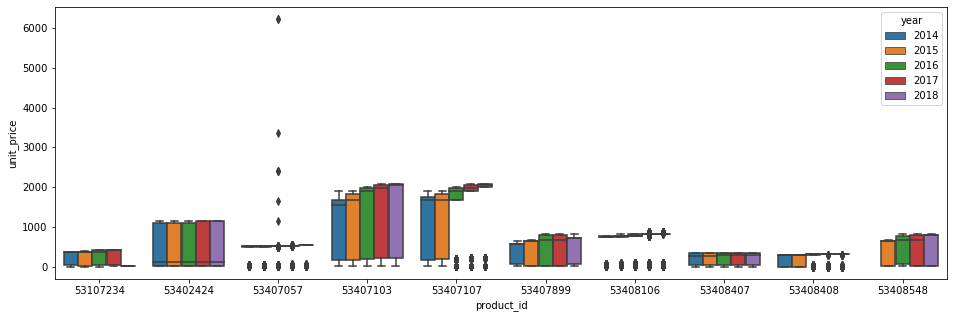

In [32]:
plt.figure(figsize=(16, 5))
sns.boxplot(data=products_df, x='product_id', y='unit_price', hue='year')

We found something interesting in here, the prices of some products, it seems that the prece haven't change at all in some products between different year, this is strange we expect that year by year the prices increments and we are not seeing that here.

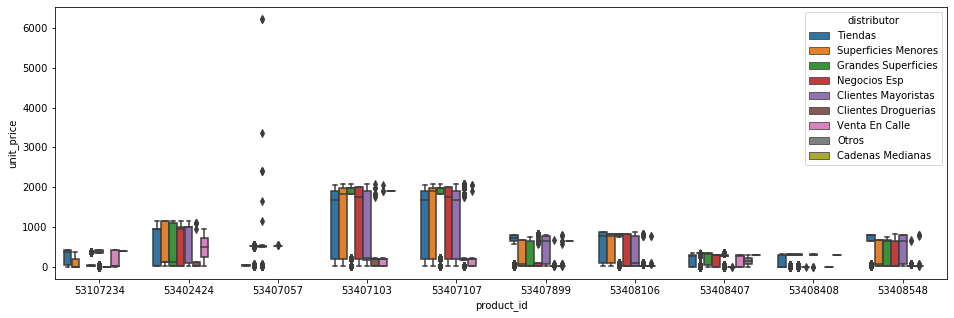

In [33]:
plt.figure(figsize=(16, 5))
sns.boxplot(data=products_df, x='product_id', y='unit_price', hue='distributor')

Now we can see that some distributors appear to be receiving different prices, why is that happening? how can we digg a little bit more into that? also we are seeing that prices still present a big variance, why is that?

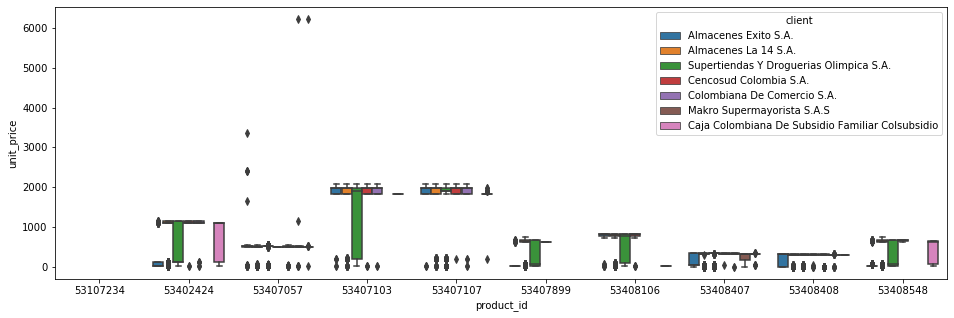

In [34]:
plt.figure(figsize=(16, 5))
sns.boxplot(data=products_df, x='product_id', y='unit_price', hue='client')

This is a very interesting chart, this shows that `SnaCo` have a prefference to sell products with bit discount to some clients, why this is happening? it is really worth it for the company to give discounts to those clients?

* The product 52407107 have a very stable price range in all distributors, if we compare in the distribution by year we can see this is one of the products that year by year is incrementing it's price, there are some outliers but overall it presents a very understandable behavior.
* product 53407103 have a lot of special prices for `Supertiendas Y Droguerias Olimpica S.A.` but in overall it's presenting a more higher mean on the prices, maybe that is showing that the the strategy of promotions it's working with olimpica, we can validate this against the volume of orders in terms of other clients.
* `Cencosud` is a client that is presenting a common price across all products, we can validate this checking the amount of sales amount that cencosud is presenting against other clients.

We need to check also if the price strategy is also related with the different offices, maybe some offices handles different prices for products?

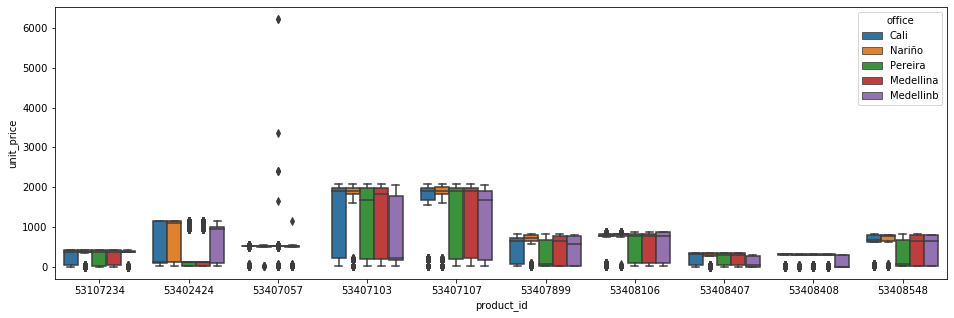

In [35]:
plt.figure(figsize=(16, 5))
sns.boxplot(data=products_df, x='product_id', y='unit_price', hue='office')

Generally speaking it seems that prices teng to stay the same in every office, it's more relevant the changes that we see in clients, we identify that there are probably policies to prices for some of the clients.

If we plot the clients and distributors for how many sales and how many amount of money the sales are producing we can compare it to the price strategy in order to see if the strategy is working.

We can select two particular products that presents different policies between clients and see how the sales behaves.

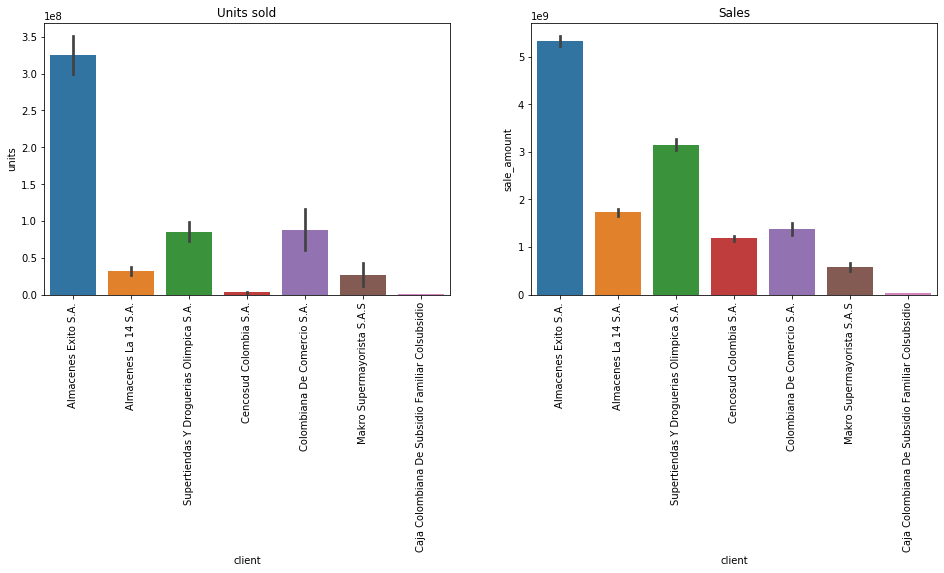

In [59]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
chart = sns.barplot(x='client', y='units', estimator=sum, data=products_df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.set_title('Units sold')

plt.subplot(1, 2, 2)
chart = sns.barplot(x='client', y='sale_amount', estimator=sum, data=products_df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.set_title('Sales')

plt.show()

We can see multiple interesting things in here, in the plot of prices distributions in general terms, we can see that `Supertiendas y Droguerias Olimpica S.A.` is buying more products, but the client `Almacenes Exito S.A.` is making more money for the `SnaCo` company, this can be evidence of the prices policy adapted by the company to sell to olimpica is not working, but we cannot conclude this yet, we need to see the sale for each product and see if olimpica si buying similar amounts than exito in order to concluse this.

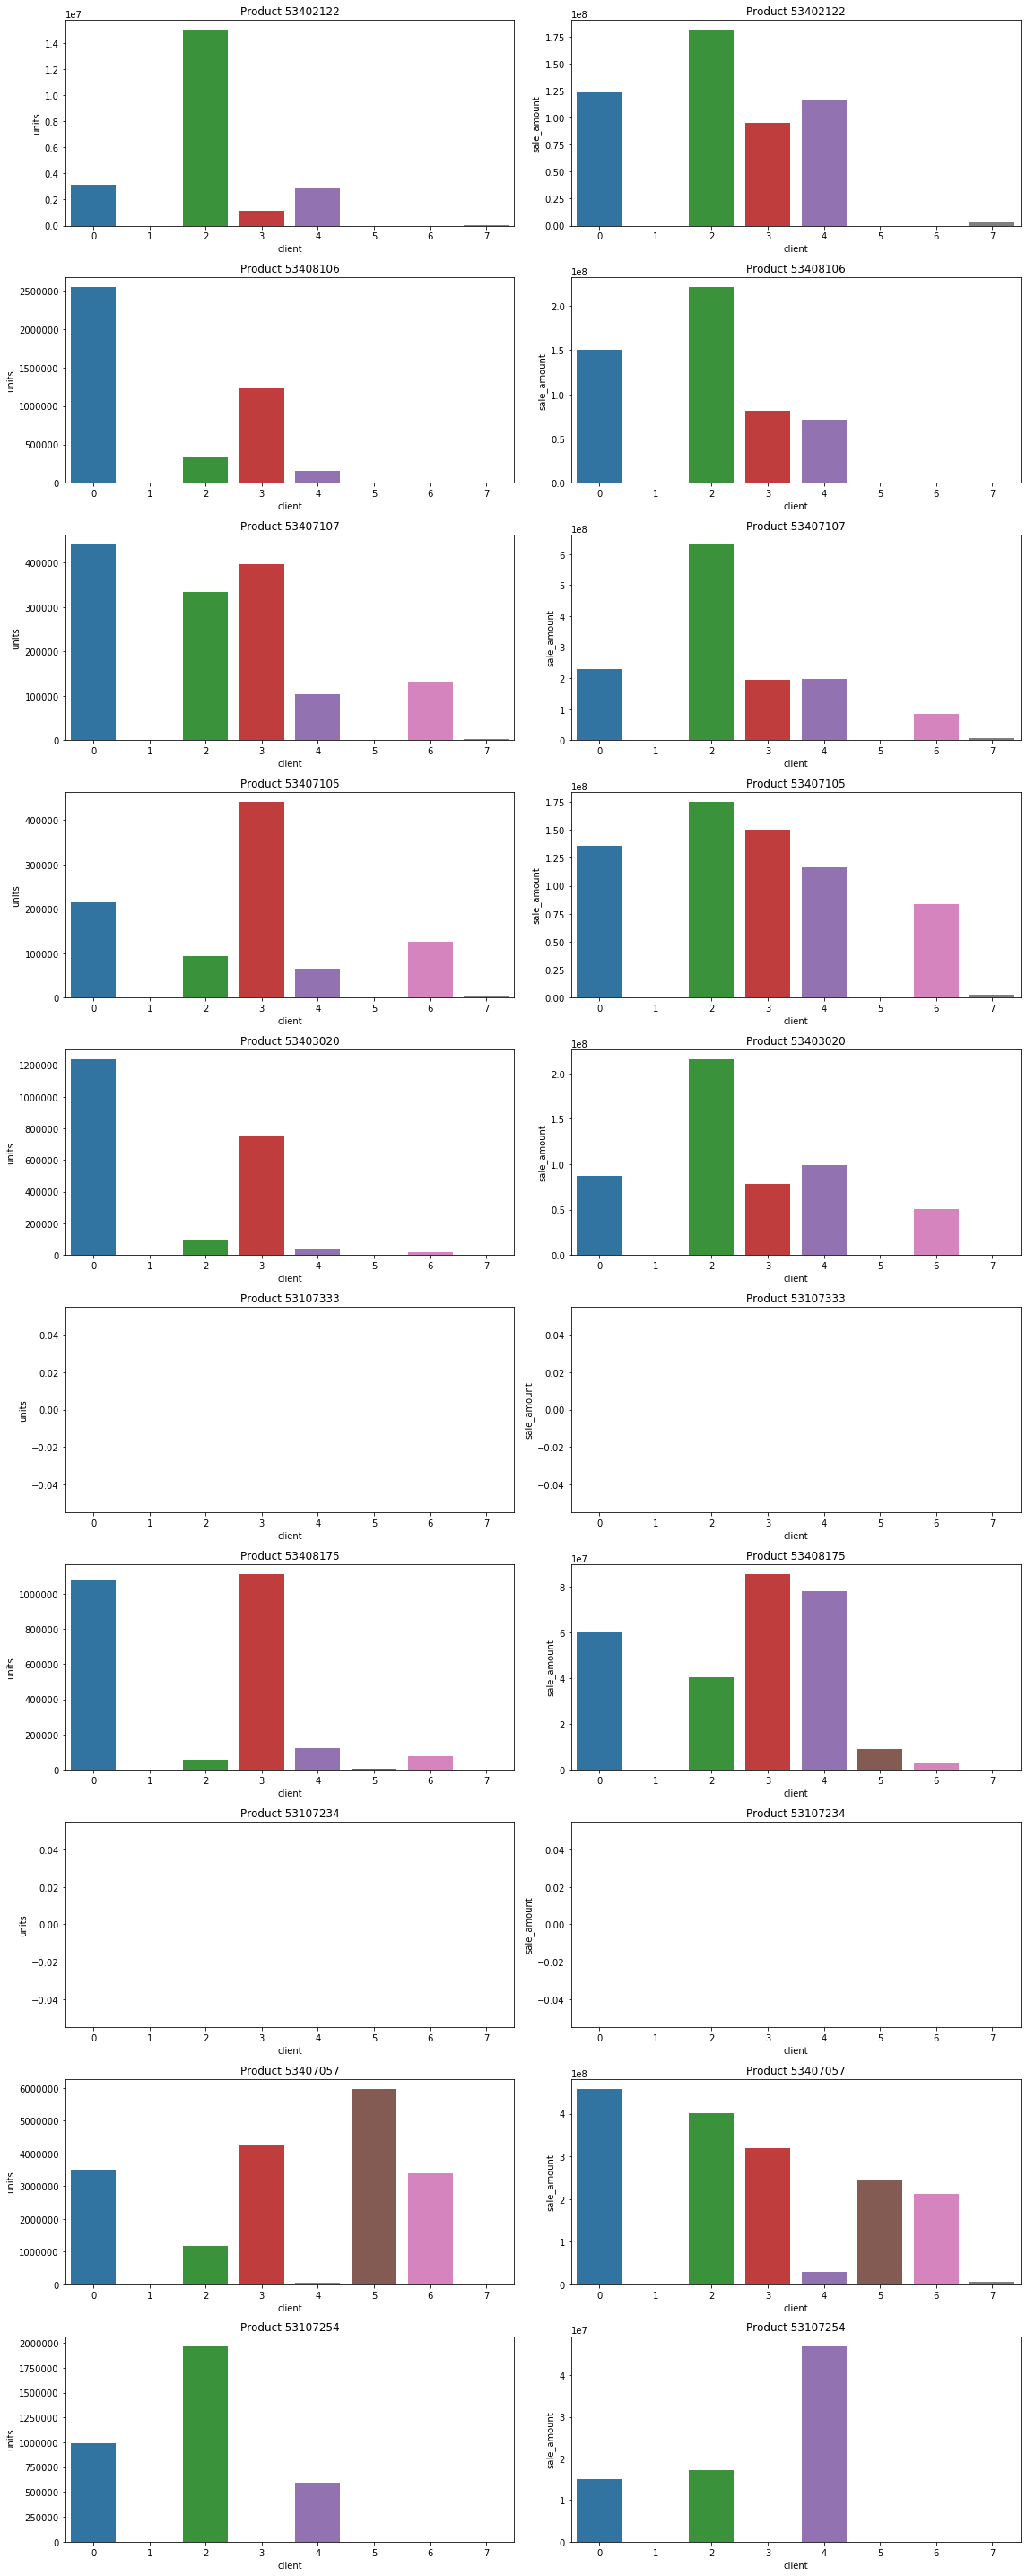

In [13]:
plt.figure(figsize=(16, 40))

products = products_df['product_id'].unique()
clients = products_df['client'].unique()

for index, product in enumerate(products):
    client_indexes = list(range(len(clients)))
    data = { 'client': client_indexes, 'units': [], 'sale_amount': [] }
    for client in clients:
        df = products_df[(products_df['client'] == client) & (products_df['product_id'] == product)]
        data['units'].append(df['units'].sum())
        data['sale_amount'].append(df['sale_amount'].sum())
    
    data = pd.DataFrame.from_dict(data)
    plt.subplot(len(products), 2, index * 2 + 1)
    sns.barplot(x='client', y='units', data=data).set_title(f"Product {product}")
    
    plt.subplot(len(products), 2, index * 2 + 2)
    chart = sns.barplot(x='client', y='sale_amount', data=data).set_title(f"Product {product}")

plt.tight_layout()

In [14]:
for index, client in enumerate(clients):
    print(f"Client {client} is index: {index}")

Client Supertiendas Y Droguerias Olimpica S.A. is index: 0
Client nan is index: 1
Client Almacenes Exito S.A. is index: 2
Client Almacenes La 14 S.A. is index: 3
Client Cencosud Colombia S.A. is index: 4
Client Makro Supermayorista S.A.S is index: 5
Client Colombiana De Comercio S.A. is index: 6
Client Caja Colombiana De Subsidio Familiar Colsubsidio is index: 7


Focusing on one interesting product that is the `5348106` let's dig in a little bit into the distribution.

In [15]:
product_id = '53408106'

product_df = products_df[products_df['product_id'] == product_id]

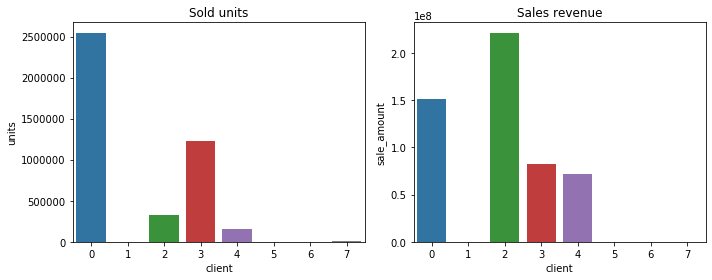

In [16]:
plt.figure(figsize=(10, 4))

client_indexes = list(range(len(clients)))
data = { 'client': client_indexes, 'units': [], 'sale_amount': [] }
for client in clients:
    df = product_df[product_df['client'] == client]
    data['units'].append(df['units'].sum())
    data['sale_amount'].append(df['sale_amount'].sum())

data = pd.DataFrame.from_dict(data)
plt.subplot(1, 2, 1)
sns.barplot(x='client', y='units', data=data).set_title('Sold units')

plt.subplot(1, 2, 2)
chart = sns.barplot(x='client', y='sale_amount', data=data).set_title('Sales revenue')

plt.tight_layout()

/Users/juanprq/anaconda3/envs/week8/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


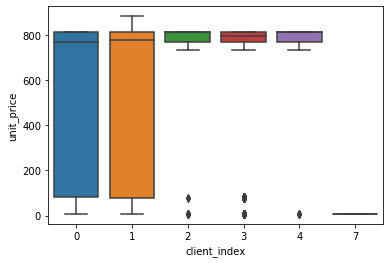

In [17]:
clients_map = {}
for index, client in enumerate(clients):
    clients_map[client] = index

product_df['client_index'] = product_df['client'].map(lambda x: clients_map[x])
client_indexes = list(range(len(clients)))
sns.boxplot(x='client_index', y='unit_price', data=product_df)

/Users/juanprq/anaconda3/envs/week8/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/juanprq/.local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/juanprq/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:789: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/juanprq/.local/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/juanprq/.local/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


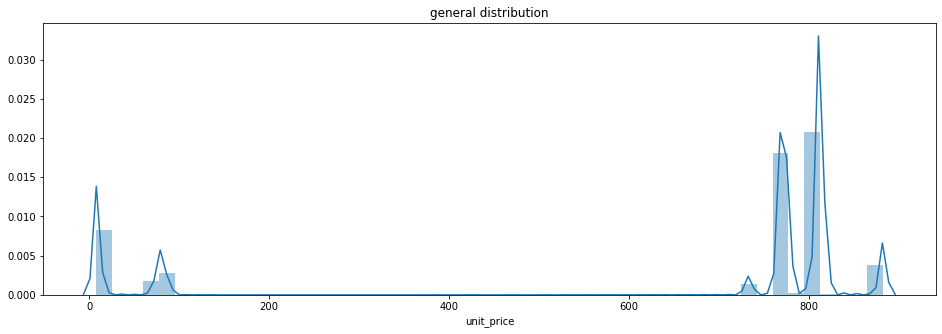

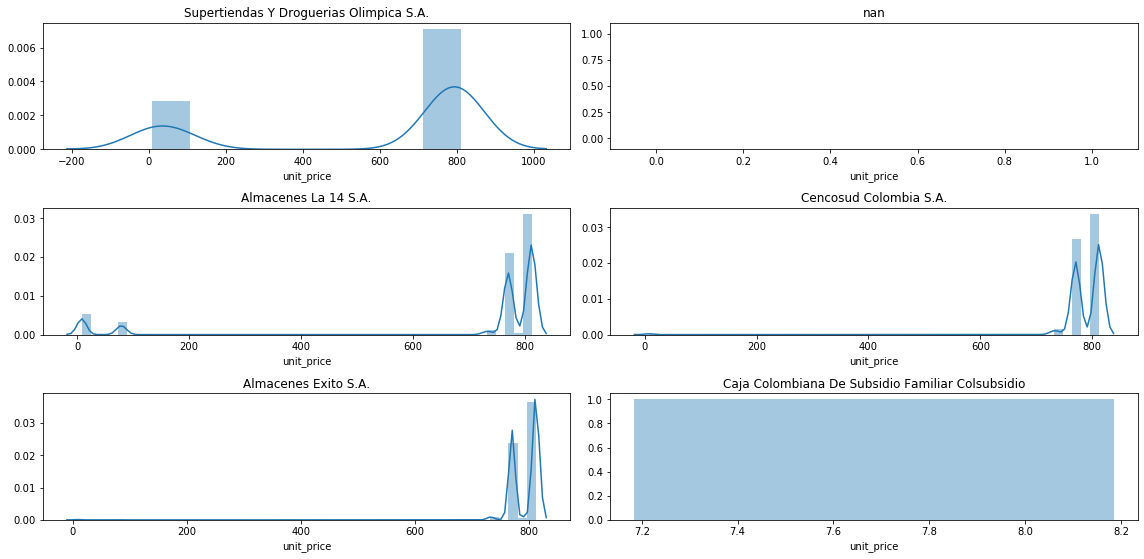

In [18]:
plt.figure(figsize=(16, 5))
sns.distplot(product_df['unit_price']).set_title('general distribution')

clients = product_df['client'].unique()
plt.figure(figsize=(16, 10))
for index, client in enumerate(clients):
    plt.subplot(4, 2, index + 1)
    sns.distplot(product_df[product_df['client'] == client]['unit_price']).set_title(client)
plt.tight_layout()

How is possible that there are some sales that the unit price is less than 1/4 of the price of other clients? this doesn't make any sense.

Let's define a limit for the product, let's examine sales that are under 500 of price and see what we can discover in here.

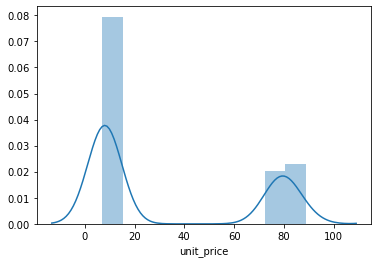

In [19]:
limit = 500

small_df = product_df[product_df['unit_price'] < 500]
sns.distplot(small_df['unit_price'])

How is even possible to have such a low values of prices? at what dates are this happening? and what amount of sales this represents?

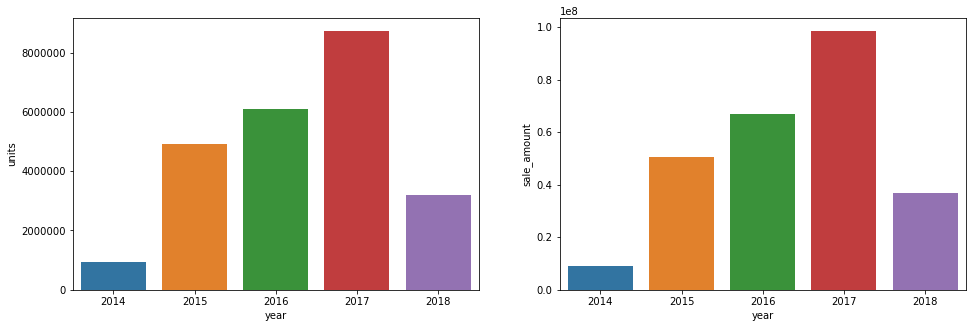

In [20]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='year', y='units', data=small_df.groupby('year')['units'].sum().reset_index())

plt.subplot(1, 2, 2)
sns.barplot(x='year', y='sale_amount', data=small_df.groupby('year')['sale_amount'].sum().reset_index())

How is even possible to sale 2500 units in 2014 for 40.000$ pesos?

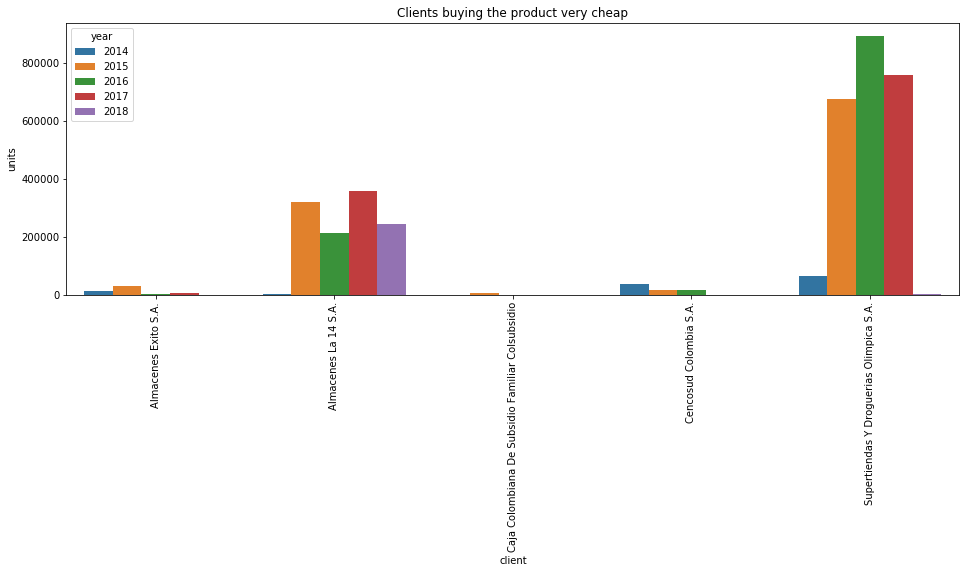

In [21]:
plt.figure(figsize=(16, 5))

chart = sns.barplot(x='client', y='units', hue='year', data=small_df.groupby(['client', 'year'])['units'].sum().reset_index())
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.set_title('Clients buying the product very cheap')

plt.show()

As the evidence of the prices distribution suggest the client `Supertiendas Y Droguerias Olimpica S.A.` is the client that is getting the better prices, also `Almacenes La 14 S.A.` (at least for this product).

Let's see how much is missing the `SnaCo` company for selling at this prices to `Almacenes la 14 S.A.` and `Supsertiendas y Droguerías Olimpica S.A`.

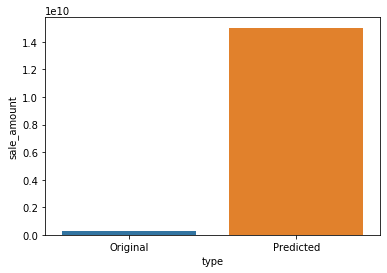

In [22]:
mean_price = product_df['unit_price'].mean()

original_sale_amount = small_df['sale_amount'].sum()
predicted_sale_amount = small_df['units'].sum() * mean_price

df = pd.DataFrame({'type': ['Original', 'Predicted'], 'sale_amount': [original_sale_amount, predicted_sale_amount]})

sns.barplot(x='type', y='sale_amount', data=df)

In [23]:
original_sale_amount, predicted_sale_amount

(262083294.0, 15026056178.344313)